# MAPS model choices
Explore options for modeling the proportions of singletons against mutability. 

## Preliminaries

In [29]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from src.constraint import maps
from src import constants as C
from src.visualisation import colour_tools as cl

In [30]:
# Module constants
_P = cl.colour_palette()

Load the data for synonymous contexts.

In [31]:
syn = pd.read_csv(C.PS_SYN_CONTEXT, sep="\t")
syn_copy = syn.copy()
print(f"Synonymous contexts: {len(syn)}")

Synonymous contexts: 304


Drop contexts with no singletons

In [32]:
syn = syn.query("ps != 0")
print(f"Synonymous contexts with at least one singleton variant: {len(syn)}")

Synonymous contexts with at least one singleton variant: 258


Plot the relationship between proportion singletons and mutability.

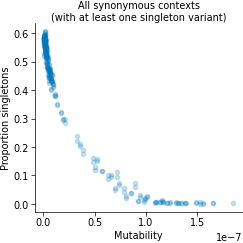

In [33]:
x = syn["mu"]
y = syn["ps"]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

def plot_ps_vs_mu(x, y, ax = ax, **kwargs):
    """Plot proportion of singletons vs mutability."""

    ax.scatter(x, y, alpha=0.2, marker="o")
    ax.set_xlabel("Mutability")
    ax.set_ylabel("Proportion singletons")
    ax.set_title("All synonymous contexts\n(with at least one singleton variant)")

    return ax

plot_ps_vs_mu(x,y);


Linearise the data with a log transformation of PS.

Text(0.5, 1.0, 'All synonymous contexts\n(with at least one singleton variant)')

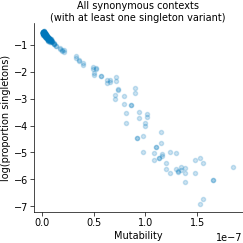

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x, np.log(y), alpha=0.2, marker="o")
ax.set_xlabel("Mutability")
ax.set_ylabel("log(proportion singletons)")
ax.set_title("All synonymous contexts\n(with at least one singleton variant)")


Try a square-root transformation of mu.

Text(0.5, 1.0, 'All synonymous contexts\n(with at least one singleton variant)')

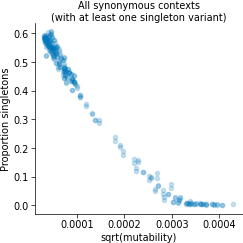

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")
ax.scatter(np.sqrt(x), y, alpha=0.2, marker="o")
ax.set_xlabel("sqrt(mutability)")
ax.set_ylabel("Proportion singletons")
ax.set_title("All synonymous contexts\n(with at least one singleton variant)")


It is not straightforward to linearise the data.

## Modelling CpGs and non-CpGs jointly

### Linear model of log(PS) vs mu

A log transformation of PS nearly linearises the data. How does a WLS model built on this transformed data perform across all synonymous contexts?

In [55]:
# Linear model for log(PS) vs mu
x = syn.mu
X = sm.tools.add_constant(x)
y = np.log(syn.ps)
w = syn["n_obs"]

model = sm.WLS(y, X, weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.991
Model:                            WLS   Adj. R-squared:                  0.991
No. Observations:                 258   F-statistic:                 2.950e+04
Covariance Type:            nonrobust   Prob (F-statistic):          2.14e-266
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5136      0.008    -67.458      0.000      -0.529      -0.499
mu         -3.956e+07    2.3e+05   -171.765      0.000      -4e+07   -3.91e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It has good performance overall. But how do the fitted values compare to the observed values?

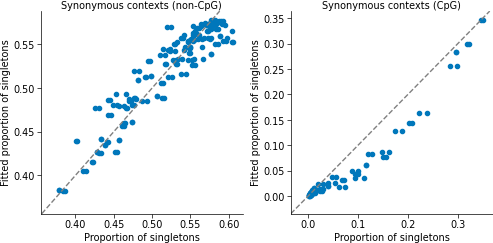

In [37]:
# Get fitted values
syn["fit_ps"] = np.exp(results.predict(sm.add_constant(syn.mu)))

# Separate CpG and non-CpG contexts
cpg = syn[syn.variant_type == "CpG"].copy()
non = syn[syn.variant_type == "non-CpG"].copy()

# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")

# Non-CpGs
axs[0].scatter(x=non.ps, y=non.fit_ps)
axs[0].set_title("Synonymous contexts (non-CpG)")

# CpGs
axs[1].scatter(x=cpg.ps, y=cpg.fit_ps)
axs[1].set_title("Synonymous contexts (CpG)")

# Add x = y line
for ax in axs:
    ax.axline(
        (min(ax.get_xlim()), min(ax.get_xlim())),
        slope=1,
        color="grey",
        linestyle="--",
    )
    ax.set_xlabel("Proportion of singletons")
    ax.set_ylabel("Fitted proportion of singletons")

There is a good fit for non-CpG contexts. But a poor fit for CpG contexts.

### Polynomial equation for PS vs mu

A second degree polynomial does well for PS vs mu in CpG contexts. Could this approach be appplied to the whole dataset?

In [38]:
# Fit a polynomial equation to PS vs mu
x = syn.mu
y = syn.ps
w = syn.n_obs

z = np.polyfit(
    x,
    y,
    deg=2,
    w=w,
)
p = np.poly1d(z)

syn["fit_ps"] = p(syn.mu)

In [39]:
# Get model statistics
model = sm.WLS(
    syn.fit_ps,
    sm.tools.add_constant(syn.mu),
    weights=w,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.885
Model:                            WLS   Adj. R-squared:                  0.884
No. Observations:                 258   F-statistic:                     1968.
Covariance Type:            nonrobust   Prob (F-statistic):          3.58e-122
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4909      0.003    153.171      0.000       0.485       0.497
mu         -4.301e+06    9.7e+04    -44.358      0.000   -4.49e+06   -4.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

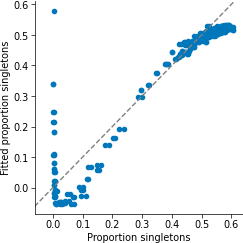

In [40]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = syn.ps, y = syn.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

No, this won't work.

### Polynomial equation for PS vs sqrt(mu)
What about with a square-root transformation of mu?

In [41]:
# Fit a polynomial equation to PS vs sqrt(mu)
x = np.sqrt(syn.mu)
y = syn.ps
w = syn.n_obs

z = np.polyfit(
    x,
    y,
    deg=2,
    w=w,
)
p = np.poly1d(z)

syn["fit_ps"] = p(np.sqrt(syn.mu))

In [42]:
# Get model statistics
model = sm.WLS(
    syn.fit_ps,
    sm.tools.add_constant(np.sqrt(syn.mu)),
    weights=w,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.984
No. Observations:                 258   F-statistic:                 1.603e+04
Covariance Type:            nonrobust   Prob (F-statistic):          6.82e-233
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6133      0.002    345.770      0.000       0.610       0.617
mu         -1840.0307     14.532   -126.620      0.000   -1868.648   -1811.413
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

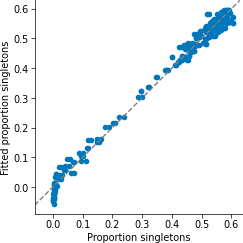

In [43]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = syn.ps, y = syn.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

This is much better, although the model is not performant for very highly mutable CpG sites. Let's test the performance of the model on our MAPS data.

In [44]:
# Calculate MAPS using the joint model, above.
df = pd.read_csv(C.PS_REGIONS, sep="\t")
maps.maps(df, p)

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,1.320782e-08,5958613,12358828,0.482134,0.375253,0.107,0.000142,0.000279
1,stop_gained,1.749916e-08,238811,425204,0.561639,0.335668,0.226,0.000761,0.001491
2,synonymous_variant,1.509552e-08,2412504,5579026,0.432424,0.356921,0.076,0.000210,0.000411
3,distal_nmd,1.557515e-08,54382,101427,0.536169,0.352508,0.184,0.001566,0.003069
4,long_exon,1.479470e-08,15857,26309,0.602722,0.359737,0.243,0.003017,0.005913
5,nmd_target,1.934344e-08,145625,256243,0.568308,0.320671,0.248,0.000978,0.001918
6,start_proximal,1.249526e-08,22947,41225,0.556628,0.382617,0.174,0.002447,0.004796


The MAPS scores for synonymous sites are too high. This suggests that the model systematically under-estimates the proportion of singletons. This looks especially true for CpG sites in the scatter plot above.

## Modelling CpG and non-CpG contexts separately
One option is to model CpG and non-CpG contexts separately.

### Non-CpGs

Below we plot PS vs mu for non-CpG variants.

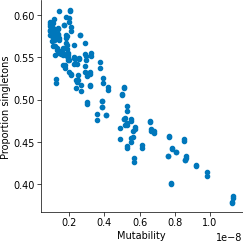

In [45]:
# Plot proportion of singletons vs mutability for non-CpG sites
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5), layout="constrained")
ax.scatter(x = non.mu, y = non.ps)
ax.set_xlabel("Mutability")
ax.set_ylabel("Proportion singletons");

The relationship is not quite linear, but it is made more so by a square root transformation of mu, as shown below.

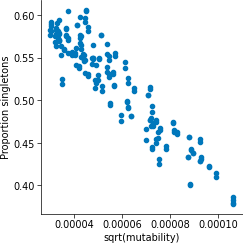

In [46]:
# Plot proportion of singletons vs sqrt(mu) for non-CpG sites
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5), layout="constrained")
ax.scatter(x = np.sqrt(non.mu), y = non.ps)
ax.set_ylabel("Proportion singletons")
ax.set_xlabel("sqrt(mutability)");

How does a model built on PS vs sqrt(mu) perform?

In [47]:
# WLS model for non-CpG contexts
x = np.sqrt(non.mu)
X = sm.tools.add_constant(x)
y = non.ps
w = non["n_obs"]

model = sm.WLS(y, X, weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.897
Model:                            WLS   Adj. R-squared:                  0.897
No. Observations:                 176   F-statistic:                     1519.
Covariance Type:            nonrobust   Prob (F-statistic):           6.96e-88
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6666      0.005    131.643      0.000       0.657       0.677
mu         -2578.4981     66.162    -38.972      0.000   -2709.082   -2447.914
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

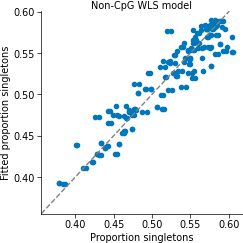

In [48]:
# Plotting fitted vs observed values for the non-CpG model
non["fit_ps"] = results.predict(sm.add_constant(np.sqrt(non.mu)))

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

ax.scatter(x=non.ps, y=non.fit_ps)
ax.set_title("Non-CpG WLS model")
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

It performs reasonably well.

### CpGs

Can we fit a polynomial to the CpG data with either:
- no transformations
- log-transformation of PS
- sqrt-transformation of mu?

Try first with no transformation.

In [49]:
# Fit a polynomial equation to PS vs mu
x = cpg.mu
y = cpg.ps
w = cpg.n_obs

z = np.polyfit(x, y, deg=2, w=w)
p = np.poly1d(z)

cpg["fit_ps"] = p(cpg.mu)

In [50]:
# Get model statistics
model = sm.WLS(cpg.fit_ps, sm.tools.add_constant(cpg.mu), weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.896
Model:                            WLS   Adj. R-squared:                  0.895
No. Observations:                  82   F-statistic:                     688.4
Covariance Type:            nonrobust   Prob (F-statistic):           4.70e-41
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3311      0.010     31.862      0.000       0.310       0.352
mu         -2.782e+06   1.06e+05    -26.238      0.000   -2.99e+06   -2.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

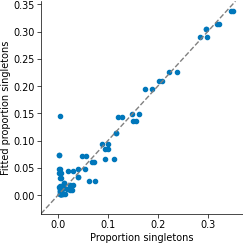

In [51]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = cpg.ps, y = cpg.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

This performs really nicely.

For consistency with the non-CpG data, can we apply a square-root transformation to mu for the CpG data also?

In [56]:
# Fit a polynomial equation to PS vs sqrt(mu)
x = np.sqrt(cpg.mu)
y = cpg.ps
w = cpg.n_obs

z = np.polyfit(x, y, deg=2, w=w)
p = np.poly1d(z)

cpg["fit_ps"] = p(np.sqrt(cpg.mu))

In [57]:
# Get model statistics
model = sm.WLS(cpg.fit_ps, sm.tools.add_constant(np.sqrt(cpg.mu)), weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.945
Model:                            WLS   Adj. R-squared:                  0.944
No. Observations:                  82   F-statistic:                     1365.
Covariance Type:            nonrobust   Prob (F-statistic):           4.84e-52
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4771      0.011     42.678      0.000       0.455       0.499
mu         -1391.6671     37.662    -36.952      0.000   -1466.616   -1316.718
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

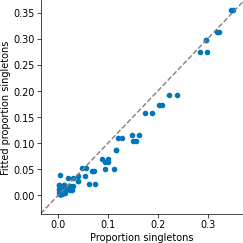

In [58]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = cpg.ps, y = cpg.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

This model does not fit the data so well.

## Conclusions

For now, let's try calculating MAPS for CpGs and non-CpGs separately. For non-CpGs, I will use a linear model of PS vs sqrt(mu). For CpGs, I will use a polynomial model of PS vs mu. We will see how it performs in practice.

## Plot proportion of singletons vs mutability

In [52]:
def plot_ps_vs_mu(ax, x, y, ylabel="Proportion singletons", xlabel="Mutability", title="All contexts"):

    ax.scatter(x, y, alpha=0.3, linewidths=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return None

In [53]:
def plot_ps_vs_mu_regression(ax, x, y, model, **kwargs):
    
    plot_ps_vs_mu(ax, x, y, **kwargs)

    Y = model.predict(sm.add_constant(x))
    ax.plot(x, Y)

    fig.text(x=1, y=0.9, s=rf"$R^2$ = {model.rsquared:.3f}", transform=ax.transAxes, ha="right", va="top")

In [54]:
fig, axs = plt.subplots(1,3, figsize=(12*cm,4*cm), layout="constrained")

plot_ps_vs_mu(axs[0], x, y)
plot_ps_vs_mu_regression(axs[1], x1, np.log(y1), model, ylabel="Proportion\nsingletons (log)")
plot_ps_vs_mu_regression(axs[2], x2, np.log(y2), model2, ylabel="Proportion\nsingletons (log)", title="Non-CpG contexts")

for a, s in zip(axs, list("ABC")):
    panel_label(a,s)
    
plt.savefig("../plots/maps_model.svg", format="svg")
plt.savefig("../plots/maps_model.png", format="png", dpi=1000)

NameError: name 'cm' is not defined